# Week 5 - ML Model Evaluation

**Data Used:** week2_data_for_student_lab.csv.gz

In [2]:
# Installing the packages
!pip install pyspark
!pip install findspark

In [3]:
# Setting up pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [4]:
# Importing packages -- numpy, pandas, matploylib, and the like
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Reading data using pyspark
df_2018_demo = spark.read.csv(f"/content/drive/MyDrive/ TERM 7/MACHINE/churn_prediction/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
print(f"{df_2018_demo.show(5)}")
df_2018_demo.createOrReplaceTempView("df_2018_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [7]:
# Checking first 5 rows of data
spark.sql('''
SELECT
  *
FROM
  df_2018_view
LIMIT
  5
''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [8]:
# Mounted my GDrive and home directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Created modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH
customers_in_jul AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-07-01' AND '2018-07-31'
),
transactions_last_3_months AS (
    SELECT
        a.member_id,
        b.amount,
        b.category_name,
        b.transaction_date,
        MONTH(b.transaction_date) AS month_num
    FROM customers_in_jul AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
),
aggregated_features AS (
    SELECT
        member_id,
        COUNT(transaction_date) AS total_txns,
        SUM(CASE WHEN month_num = 6 THEN amount ELSE 0 END) AS june_spent,
        SUM(CASE WHEN month_num = 5 THEN amount ELSE 0 END) AS may_spent,
        SUM(CASE WHEN month_num = 4 THEN amount ELSE 0 END) AS april_spent
    FROM transactions_last_3_months
    GROUP BY member_id
),
customers_with_target AS (
    SELECT
        a.member_id,
        CASE WHEN total_txns = 0 THEN 1 ELSE 0 END AS target,
        b.*
    FROM customers_in_jul AS a
    LEFT JOIN aggregated_features AS b
    ON a.member_id = b.member_id
)
SELECT * FROM customers_with_target
''')
df_mabt.createOrReplaceTempView("df_mabt_view")

In [10]:
# Saved modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,member_id,target,member_id,total_txns,june_spent,may_spent,april_spent
0,00000864-cfdb-11eb-9633-d8f2ca37414f,0,00000864-cfdb-11eb-9633-d8f2ca37414f,1,0,2800,0
1,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,00000867-cfdb-11eb-80ce-d8f2ca37414f,0,0,0,0
2,0000086b-cfdb-11eb-81cf-d8f2ca37414f,0,0000086b-cfdb-11eb-81cf-d8f2ca37414f,4,0,13500,0
3,0000087b-cfdb-11eb-ab7f-d8f2ca37414f,0,0000087b-cfdb-11eb-ab7f-d8f2ca37414f,1,5300,0,0
4,00000880-cfdb-11eb-8d6f-d8f2ca37414f,0,00000880-cfdb-11eb-8d6f-d8f2ca37414f,5,0,5300,24400


In [11]:
# Checked column names in data
pdf_mabt.columns

Index(['member_id', 'target', 'member_id', 'total_txns', 'june_spent',
       'may_spent', 'april_spent'],
      dtype='object')

In [12]:
# Checking the summary statistics
pdf_mabt[['june_spent', 'may_spent', 'april_spent']].describe().T

,count,mean,std,min,25%,50%,75%,max
june_spent,50667.0,3834.142539,7350.768286,0.0,0.0,0.0,5300.0,96600.0
may_spent,50667.0,4094.205301,7686.516133,0.0,0.0,0.0,6000.0,83800.0
april_spent,50667.0,2742.345116,6316.751069,0.0,0.0,0.0,500.0,60800.0


In [13]:
# Check summary statistics per target definition
pdf_mabt.groupby(['target'])[['june_spent', 'may_spent', 'april_spent']].describe().T

target                        0        1
june_spent  count  34794.000000  15873.0
            mean    5583.275852      0.0
            std     8301.717292      0.0
            min        0.000000      0.0
            25%        0.000000      0.0
            50%      100.000000      0.0
            75%     8400.000000      0.0
            max    96600.000000      0.0
may_spent   count  34794.000000  15873.0
            mean    5961.979077      0.0
            std     8654.522998      0.0
            min        0.000000      0.0
            25%        0.000000      0.0
            50%     1100.000000      0.0
            75%     8900.000000      0.0
            max    83800.000000      0.0
april_spent count  34794.000000  15873.0
            mean    3993.401161      0.0
            std     7287.573122      0.0
            min        0.000000      0.0
            25%        0.000000      0.0
            50%        0.000000      0.0
            75%     6200.000000      0.0
            max    60800.000000      0.0

In [14]:
# Copying data for modeling
data = pdf_mabt[['target', 'june_spent', 'may_spent', 'april_spent']].copy()

In [15]:
# Separating target variable and features
y = data['target']
X = data.drop(['target'], axis=1)

In [16]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Model
estimator = LogisticRegression()

# Creating transformers for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        #('cat_onehot', OneHotEncoder(handle_unknown='ignore'), [])
        #,
         ('num_standard', StandardScaler(), ['june_spent', 'may_spent', 'april_spent'])
        #,('num_minmax', MinMaxScaler(), [])
    ],
    remainder='passthrough',
)

# Created a logistic regression model using a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
    ,('estimator', estimator)
])

# Fit training data into model pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  StandardScaler(),
                                                  ['june_spent', 'may_spent',
                                                   'april_spent'])])),
                ('estimator', LogisticRegression())])

Accuracy: 0.98
Precision: 0.95
Recall: 1.00

Confusion Matrix:
[[27255   608]
 [    0 12670]]


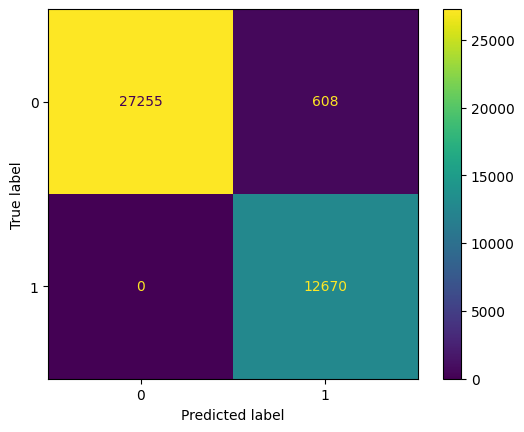

In [18]:
# Make predictions on the train set
y_pred_train = pipeline.predict(X_train)

# Evaluated the model
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)

print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"\nConfusion Matrix:")
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

Accuracy: 0.99
Precision: 0.95
Recall: 1.00

Confusion Matrix:
[[6780  151]
 [   0 3203]]


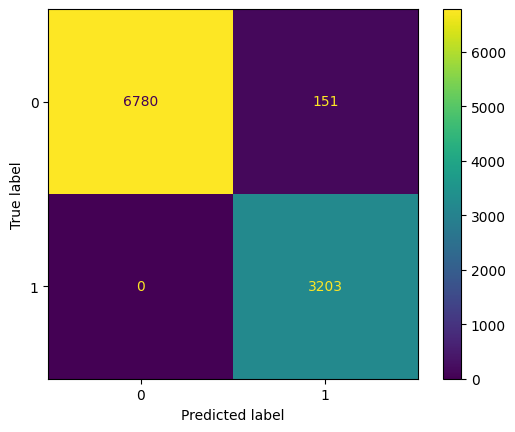

In [19]:
# Made predictions on the test set
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"\nConfusion Matrix:")
print(cm_test)

cmd_test = ConfusionMatrixDisplay(cm_test)
cmd_test.plot()

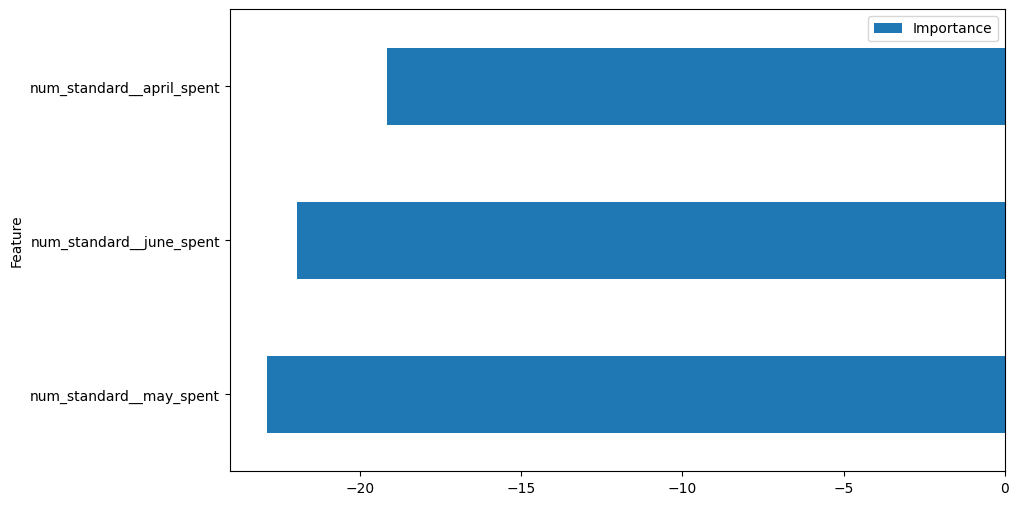

Intercept: -29.042979586848883


In [20]:
#### Get coefficients & intercept

coefficients = pipeline.named_steps.estimator.coef_[0]
feature_names = pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

# Observation and Analysis

Based on my observation and analysis in this 5th week's assessment, this performs an great job of developing and testing a logistic regression model to predict client attrition. It begins with data processing in PySpark and then generates a modeling dataset (ABT) with transaction-based attributes. The model pipeline uses feature scaling and achieves 99% accuracy on the test set. However, the model's perfect recall (1.00) and very high precision (0.95) indicate that it may be overfitting, as it accurately labels the minority class. It may be beneficial to investigate further feature engineering, new models, or cross-validation to ensure that the results hold up in various contexts.